# 6. Prediction Models

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import xgboost as xgb
import pickle
import seaborn as sns

from numpy import genfromtxt
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, auc, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn import model_selection, metrics, linear_model
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from matplotlib import pyplot

pd.set_option('display.max_columns', None)

The functions below compute the matrix confision and importance features for each of the models. These functions will be called later in the analysis.

In [2]:
def conf_matrix(Y_test, Y_pred):
    cnf_matrix_tra = confusion_matrix(Y_test, Y_pred)
    conf_plot = sns.heatmap(cnf_matrix_tra, annot=True, cmap='Blues', fmt='g')
    bottom, top = conf_plot.get_ylim()
    conf_plot.set_ylim(bottom + 0.5, top - 0.5)
    conf_plot.set_title("Confusion matrix, without normalization")
    conf_plot.set_ylabel('True Label')
    conf_plot.set_xlabel('Predicted Label');

In [3]:
def features_importence(coeficients):
    data = {'Features':X_train.columns, 'Coeficients':abs(coeficients)} 
    coef = pd.DataFrame(data).sort_values(by=['Coeficients'], ascending=False)
    fig, ax = pyplot.subplots(figsize=(12,10))
    coef_plot = sns.barplot(coef['Features'],coef['Coeficients'])
    coef_plot.set_xticklabels(coef_plot.get_xticklabels(), rotation=40, ha="right");

Firstly, we will build the model(save it to take up less space) and divide the sample by train to train the model and perform the prediction with test. Then, we will calculate the acuraccy of both to check if there is overfitting. Finally, we will visualize the Confusion matrix, classification statistics, the Rock curve and features that have most influenced the result of the model.

Let's try some models on the train dataset . Our goal in this analysis is to obtain an algorithm that suggests whether we grant the loan or not a future client. We are going to use the following machine learning algorithms:

## 6.1. Logistic Regresion

The purpose of a regression analysis is to investigate the statistical relationship between a dependent variable (target) with the independent variables.

In [4]:
X_train = pd.read_csv('../data/X_train.csv', low_memory=False )
X_test = pd.read_csv('../data/X_test.csv', low_memory=False)
Y_train = genfromtxt('../data/Y_train.csv', delimiter=',')
Y_test = genfromtxt('../data/Y_test.csv', delimiter=',')

In [5]:
logreg = LogisticRegression(max_iter=100)
logreg.fit(X_train, Y_train)

C:\Users\Juan Villasante\AppData\Roaming\Python\Python37\site-packages\sklearn\linear_model\_logistic.py:939: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html.
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [56]:
Y_pred = logreg.predict(X_test)

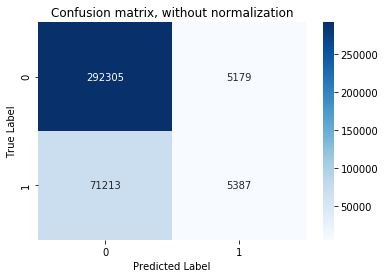

In [137]:
conf_matrix(Y_test, Y_pred)

In [138]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

         0.0       0.80      0.98      0.88    297484
         1.0       0.51      0.07      0.12     76600

    accuracy                           0.80    374084
   macro avg       0.66      0.53      0.50    374084
weighted avg       0.74      0.80      0.73    374084



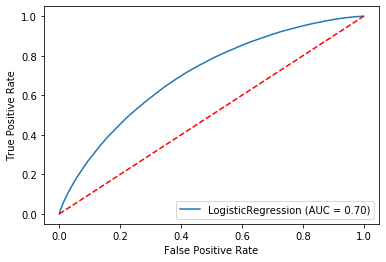

In [11]:
metrics.plot_roc_curve(logreg, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 79% of accuracy. It means that the ratio between the correct predictions the model has made and the total predictions is good apparently.

In the confusion matrix the rows are shown according to the actual decisions and the columns according to the decisions foreseen by the model. We can see that in 5179 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 72213 of the cases, the model incorrectly predicted that the positive class would be the negative class. Our main objective is to correctly identify the default (True Positive) for the loan club can decide whether a person is eligible to grant a loan or not in the future.

There are three classification statistics from the confusion matrix:

- Precision: Out of all the predicted positive instances, how many wre predicted correctly

- Recall: of all the positive classes, how many instances were correctly identified.

- F1-score: it's the harmonic mean of accuracy and recall.

We see that in the possitive class, the precision is 0.8, recall is 0.98 and f1-score is 0.88. In the negative class the precision is 0.51, recall is 0.07 and f1-score is 0.12.

The ROC curve tells us how good the model is to distinguish the given classes, in terms of the predicted probability, providing tools to select possibly optimal models and discard suboptimal models. In the plot we visualize the false positive rate in the X axis and a true positive rate in the Y axis. The area covered by the curve is the area between the blue line (ROC) and the axis. This covered area is AUC. The larger the covered area, the better the machine learning models to distinguish the classes.
In this case we see that area is not very large(AUC=0.7) so we hope to get a model with better results ahead. The ideal value for AUC is 1.

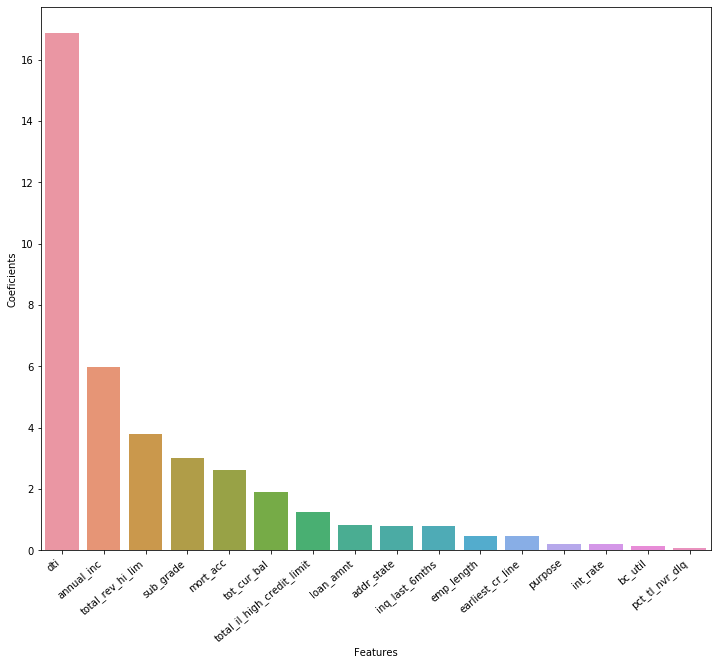

In [168]:
features_importence(logreg.coef_[0])

In this plot we represent in order of importance the coefficients of the features that the model indicates as more important in predicting the defaulter's: 'dti', 'annual_inc', 'total_rev_hi_lim, 'sub_grade', mort_acc and 'tot_cur_bal'. We would like to use this as the metric for identifying people defaulting on their loans. 

## 6.2. Support Vector Machine

Support Vector Machine given a set of points that represent the data, in which each one belongs to one of two possible categories, an SVM-based algorithm constructs a model capable of predicting whether a new point (whose category we don't know) belongs to a category or the other.

In [5]:
%%time
svclassifier = SVC(kernel='rbf', max_iter = 1000)
svclassifier.fit(X_train, Y_train)

Wall time: 1min 11s


C:\Users\Juan Villasante\AppData\Roaming\Python\Python37\site-packages\sklearn\svm\_base.py:231: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=1000, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [6]:
pred_svm = svclassifier.predict(X_test)

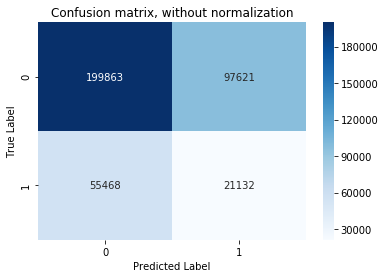

In [7]:
conf_matrix(Y_test,pred_svm)

In [6]:
print(classification_report(Y_test,pred_svm))

[[199863  97621]
 [ 55468  21132]]
              precision    recall  f1-score   support

         0.0       0.78      0.67      0.72    297484
         1.0       0.18      0.28      0.22     76600

    accuracy                           0.59    374084
   macro avg       0.48      0.47      0.47    374084
weighted avg       0.66      0.59      0.62    374084



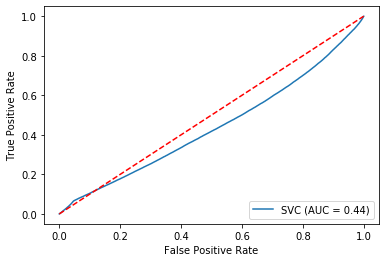

In [155]:
metrics.plot_roc_curve(svclassifier, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 59% of accuracy.

In the confusion matrix we can see that in 97621 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 55468 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.78, recall is 0.67 and f1-score is 0.72. In the negative class the precision is 0.18, recall is 0.28 and f1-score is 0.22.

In this case we see that the area is negative so we think that something must be wrong.

###  Random search SVC

In [151]:
# %%time
# 
# param_test1 = {
#     'kernel': ['linear', 'rbf', 'poly'],
#     'gamma' : [0.1, 1, 10, 100],
#     'C' : [0.01, 0.1, 1, 10, 100],
#     'degree' : [0, 1, 2, 3, 4]
#              }
# SVC_rs = RandomizedSearchCV(estimator = SVC(max_iter = 1000, random_state=1),
#                         param_distributions = param_test1, scoring='roc_auc',n_jobs=5, cv=3)
# SVC_rs.fit(X_train, Y_train)

Wall time: 0 ns


In [ ]:
# Best hyperparameters
# {'kernel': 'linear', 'gamma': 100, 'degree': 0, 'C': 0.01}

In [160]:
# pickle.dump(SVC_rs, open('../models/SVC_rs.sav', 'wb'))

In [6]:
SVC_rs = pickle.load(open('../models/SVC_rs.sav', 'rb'))

In [13]:
pred_svc_rs = SVC_rs.predict(X_test)

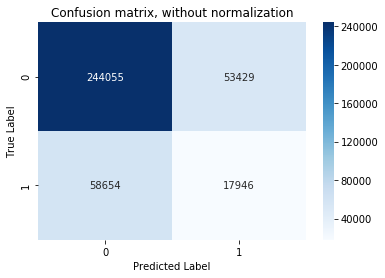

In [14]:
conf_matrix(Y_test, pred_svc_rs)

In [15]:
print(classification_report(Y_test,pred_svc_rs))

              precision    recall  f1-score   support

         0.0       0.81      0.82      0.81    297484
         1.0       0.25      0.23      0.24     76600

    accuracy                           0.70    374084
   macro avg       0.53      0.53      0.53    374084
weighted avg       0.69      0.70      0.70    374084



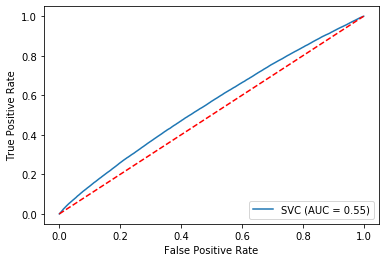

In [16]:
metrics.plot_roc_curve(SVC_rs, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 70% of accuracy.

In the confusion matrix we can see that in 53429 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 58654 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.81, recall is 0.82 and f1-score is 0.81. In the negative class the precision is 0.25, recall is 0.23 and f1-score is 0.24.

In this case we see in the ROC curve that the AUC is 0.55, worse than in the loqistic regression.

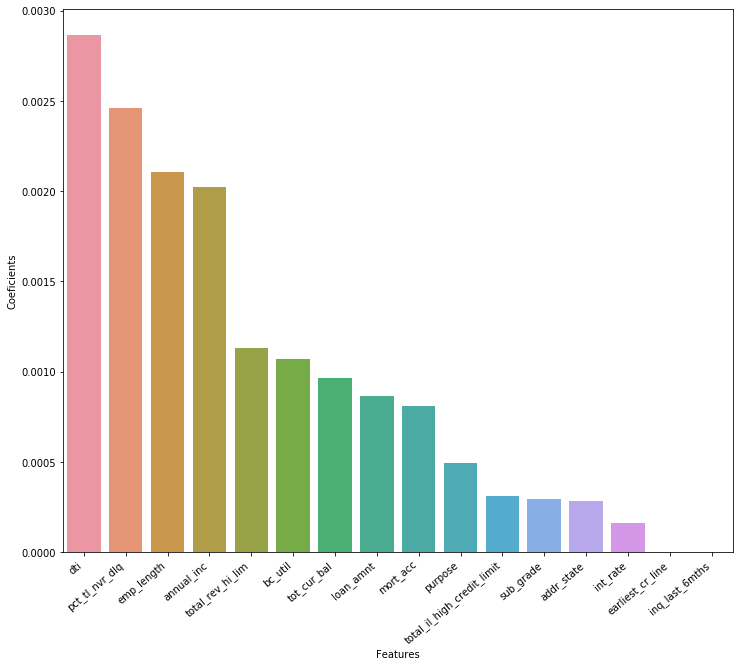

In [169]:
features_importence(SVC_rs.coef_[0])

The features that the model indicates as more important in predicting the defaulter's are: 'dti', 'pct_tl_nvr_dlq', 'emp_length', 'annual_inc', 'total_rev_hi_lim, 'bc_util', 'tot_cur_bal', 'loan amnt' and 'mort_acc'. 

## 6.3. Random Forest

Random forest is a combination of predictor trees such that each tree depends on the values of a random vector tested frequently and with the same distribution for each of these.

In [183]:
# %%time
# random_forest = RandomForestClassifier(n_estimators = 100, n_jobs=6, random_state=0)
# random_forest.fit(X_train, Y_train)

Wall time: 1min 30s


In [187]:
# pickle.dump(random_forest, open('../models/random_forest.sav', 'wb'))

In [17]:
random_forest = pickle.load(open('../models/random_forest.sav', 'rb'))

In [18]:
Y_pred_RF = random_forest.predict(X_test)

We can see a clear sign of over-fitting in these case

In [21]:
print("Random Forest score train: ", accuracy_score(Y_train, random_forest.predict(X_train)))

Random Forest score train:  0.9999816694544371


In [22]:
print("Random Forest score test: ", accuracy_score(Y_test, Y_pred_RF))

Random Forest score test:  0.7969600410602966


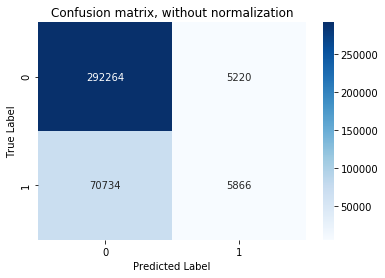

In [23]:
conf_matrix(Y_test, Y_pred_RF)

In [24]:
print(classification_report(Y_test,Y_pred_RF))

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89    297484
         1.0       0.53      0.08      0.13     76600

    accuracy                           0.80    374084
   macro avg       0.67      0.53      0.51    374084
weighted avg       0.75      0.80      0.73    374084



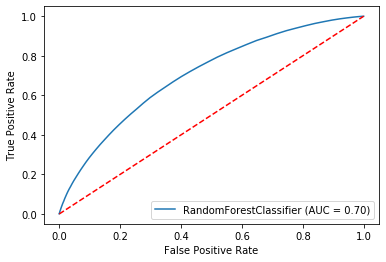

In [25]:
metrics.plot_roc_curve(random_forest, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 0.99 % of accuracy in train and 0.797% of accuracy in test.

In the confusion matrix we can see that in 5220 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 70734 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.81, recall is 0.98 and f1-score is 0.89. In the negative class the precision is 0.53, recall is 0.08 and f1-score is 0.13.

In this case we see in the ROC that the AUC is 0.7 as in the logistic regression. The difference with the logistic regression is that Random Forest model has many more features of great relevance and that the classification statistics are slightly higher.

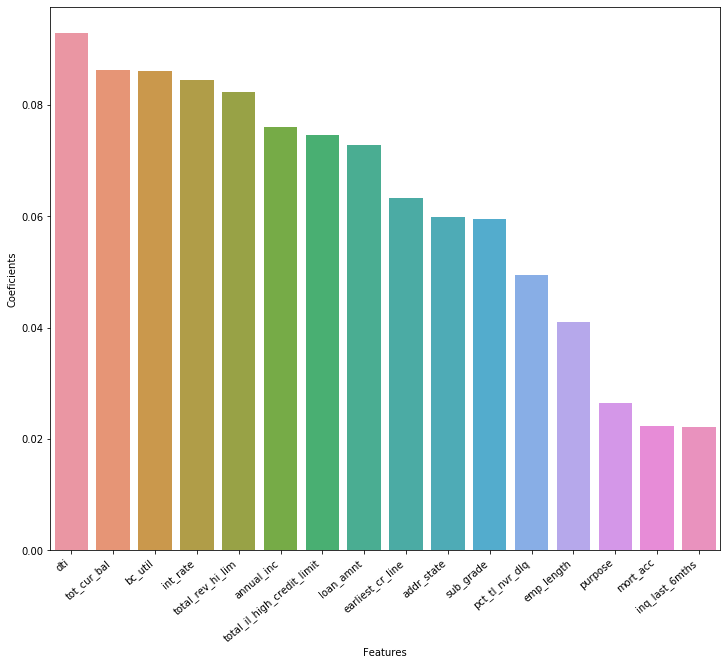

In [191]:
features_importence(random_forest.feature_importances_)

The features that the model indicates as more important in predicting the defaulter's are: 'dti', 'tot_cur_bal', 'bc_util', 'int_rate', 'total_rev_hi_lim', 'annual_inc', 'total_il_high_credit_limit', 'loan amnt', 'earliest_cr_line', 'addr_state', 'sub_grade', 'pct_tl_nvr_dlq' and 'emp_length'. 

### Random Forest with  random search

In [18]:
# %%time
# param_test1 = {
#     'bootstrap': [True, False],
#    'max_depth': [6, 8, 10, 12],
#     'max_features': ['auto', 'sqrt'],
#     'n_estimators': [100,200,300,400]
# }
# Forest_RS = RandomizedSearchCV(estimator = RandomForestClassifier(),
#                         param_distributions  = param_test1, scoring='roc_auc',n_jobs=5,iid=False, cv=3)
# Forest_RS.fit(X_train, Y_train)

In [ ]:
# Best hyperparameters
# {'n_estimators': 400, 'max_features': 'auto', 'max_depth': 12, 'bootstrap': True}

In [22]:
# pickle.dump(Forest_RS, open('../models/random_forest_SG.sav', 'wb'))

In [7]:
Forest_RS = pickle.load(open('../models/random_forest_SG.sav', 'rb'))

In [24]:
Y_pred_RF_SG = Forest_RS.predict(X_test)

In [25]:
print("Random Forest score train: ", accuracy_score(Y_train, Forest_RS.predict(X_train)))

Random Forest score train:  0.799275943450267


In [26]:
print("Random Forest score test: ", accuracy_score(Y_test, Y_pred_RF_SG))

Random Forest score test:  0.7980239732252649


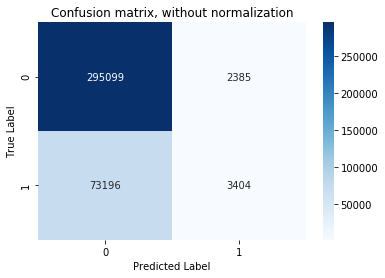

In [12]:
conf_matrix(Y_test, Y_pred_RF_SG)

In [29]:
print(classification_report(Y_test,Y_pred_RF_SG))

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89    297484
         1.0       0.59      0.05      0.08     76600

    accuracy                           0.80    374084
   macro avg       0.69      0.52      0.49    374084
weighted avg       0.76      0.80      0.72    374084



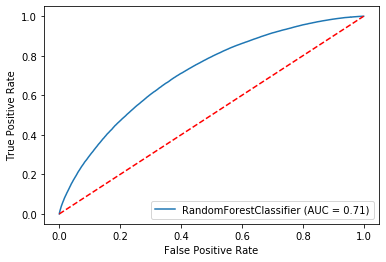

In [27]:
metrics.plot_roc_curve(Forest_RS, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 0.799 % of accuracy in train and 0.798% of accuracy in test.

In the confusion matrix we can see that in 2385 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 73196 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.80, recall is 0.99 and f1-score is 0.89. In the negative class the precision is 0.59, recall is 0.05 and f1-score is 0.08.

In this case we see in the ROC that the AUC is 0.71, a little better than in the logistic regression and in Random Forest.

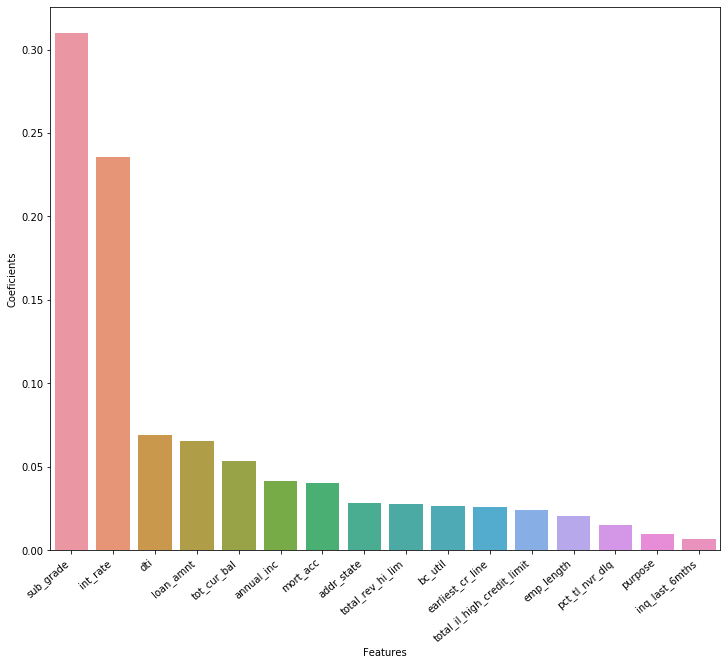

In [28]:
features_importence(Forest_RS.feature_importances_)

The features that the model indicates as more important in predicting the defaulter's are 'sub grade' and 'in_rate'. 

## 6.4. XGBoost

XGBoost is an efficient open code implementation of the gradient tree algorithm. Effectively use the large number of hyperparameters that can be modified and tuned to improve the settings.

In [40]:
# %%time
# loan_XGBoost = xgb.XGBClassifier(nthread=5)
# loan_XGBoost.fit(X_train, Y_train)

In [39]:
# pickle.dump(loan_XGBoost, open('../models/XGBoost.sav', 'wb'))

In [41]:
loan_XGBoost = pickle.load(open('../models/XGBoost.sav', 'rb'))

In [42]:
Y_pred_XG = loan_XGBoost.predict(X_test)

In [43]:
print("XGBoost score train: ", accuracy_score(Y_train, loan_XGBoost.predict(X_train)))

XGBoost score train:  0.7962926471599111


In [34]:
print("XGBoost score test: ", accuracy_score(Y_test, Y_pred_XG))

XGBoost score test:  0.7976123009805285


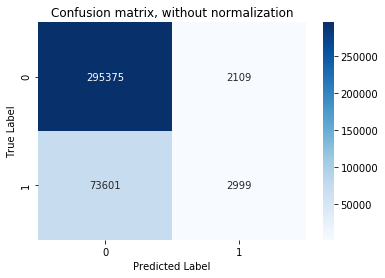

In [35]:
conf_matrix(Y_test, Y_pred_XG)

In [36]:
print(classification_report(Y_test,Y_pred_XG))

              precision    recall  f1-score   support

         0.0       0.80      0.99      0.89    297484
         1.0       0.59      0.04      0.07     76600

    accuracy                           0.80    374084
   macro avg       0.69      0.52      0.48    374084
weighted avg       0.76      0.80      0.72    374084



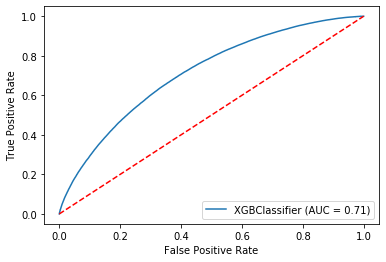

In [37]:
metrics.plot_roc_curve(loan_XGBoost, X_test, Y_test)
plt.plot([0, 1], [0, 1],'r--')
plt.show() 

In this model we get 0.796 % of accuracy in train and 0.797% of accuracy in test.

In the confusion matrix we can see that in 2109 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 73601 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.90, recall is 0.99 and f1-score is 0.89. In the negative class the precision is 0.59, recall is 0.04 and f1-score is 0.07.

In this case we see in the ROC that the AUC is 0.71, as in Random with random search. The difference between them is that the 'in_reate' feature isn't relevant in XGBoost.

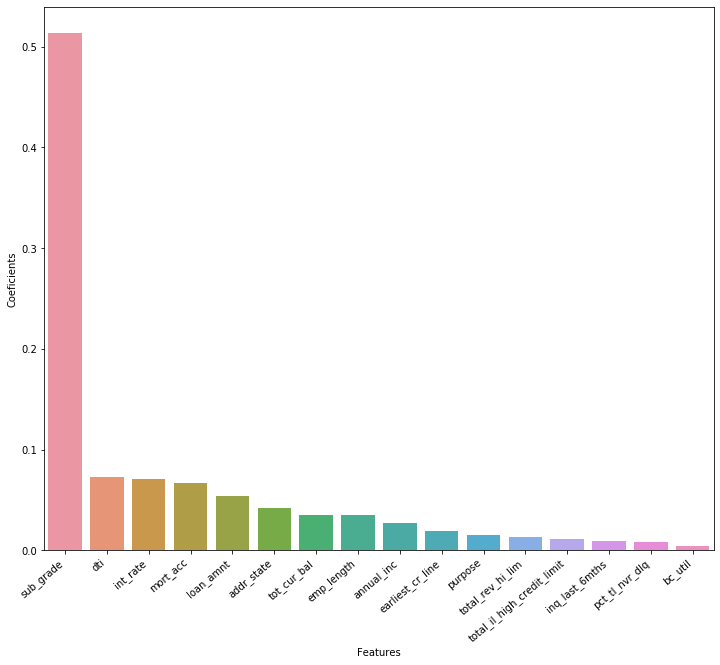

In [38]:
features_importence(loan_XGBoost.feature_importances_)

The feature that the model indicates as more important in predicting the defaulter's is 'sub_grade'.

### XGBoost con random search

In [72]:
# %%time

# param_test1 = {
#     'gamma':[i/10.0 for i in range(0,5)],
#     'learnin_rate': [i/100 for i in range(1,15)],
#     'subsample': [0.5,0.6,0.7,0.8,0.9],
#     'colsample_bytree': [0.6,0.7,0.8,0.9,1],
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,10,2),
#     'scale_pos_weight': [1]
#              }
# XGBoost_RS = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_estimators=100, seed=0),
#                         param_distributions = param_test1, scoring='roc_auc',n_jobs=5, cv=3)
# XGBoost_RS.fit(X_train, Y_train)

In [ ]:
# Best hyperparameters
# {'subsample': 0.7, 'scale_pos_weight': 1, 'min_child_weight': 5, 'max_depth': 9,
# 'learnin_rate': 0.05, 'gamma': 0.4,'colsample_bytree': 0.7}

In [70]:
#pickle.dump(XGBoost_RS, open('../models/XGBoost_RS.sav', 'wb'))

In [27]:
XGBoost_RS = pickle.load(open('../models/XGBoost_RS.sav', 'rb'))

In [28]:
Y_pred_XG_RS = XGBoost_RS.predict(X_test)

In [68]:
print("XGBoost score train: ", accuracy_score(Y_train, XGBoost_RS.predict(X_train)))

XGBoost score train:  0.8011124349838462


In [69]:
print("XGBoost score test: ", accuracy_score(Y_test, Y_pred_XG_RS))

XGBoost score test:  0.7989034548390201


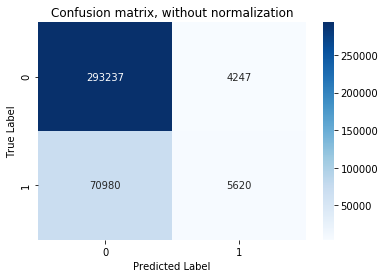

In [73]:
conf_matrix(Y_test, Y_pred_XG_RS)

In [74]:
print(classification_report(Y_test, Y_pred_XG_RS))

              precision    recall  f1-score   support

         0.0       0.81      0.99      0.89    297484
         1.0       0.57      0.07      0.13     76600

    accuracy                           0.80    374084
   macro avg       0.69      0.53      0.51    374084
weighted avg       0.76      0.80      0.73    374084



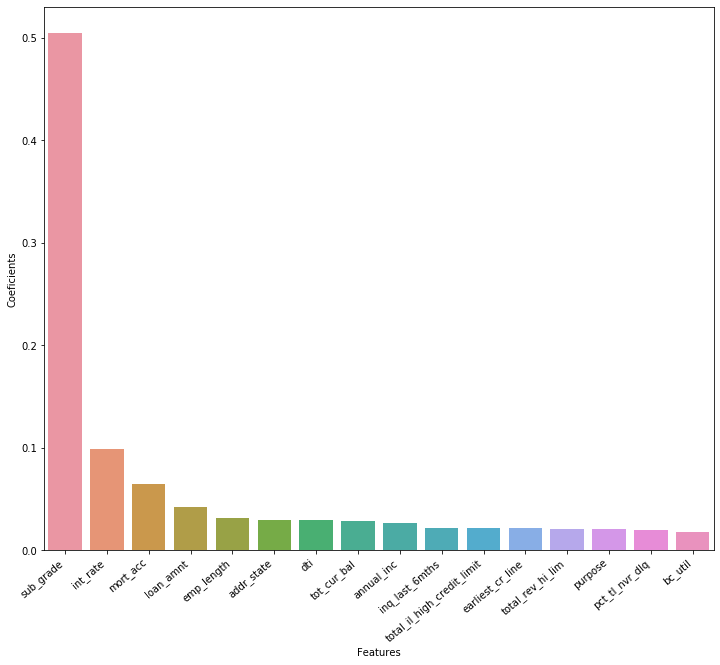

In [35]:
features_importence(XGBoost_RS.feature_importances_)
plt.savefig("images/XGBoost_feature_importance.jpg", bbox_inches="tight")

The feature that the model indicates as more important in predicting the defaulter's is 'sub_grade' again.

In [83]:
y_pred3 = XGBoost_RS.predict_proba(X_test)[:,1] 

In [84]:
logit_fpr, logit_tpr, _ = roc_curve(Y_test, y_pred3)
logit_auc = np.round(auc(logit_fpr, logit_tpr), 4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


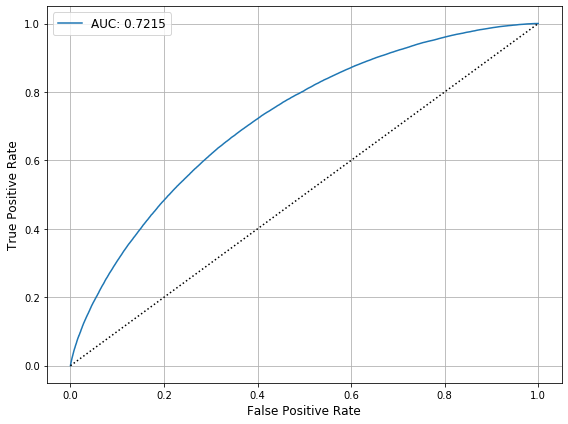

In [85]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(logit_fpr, logit_tpr, label='AUC: ' + str(logit_auc))
ax.plot(logit_fpr, logit_fpr, 'k:')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

In this model we get 0.80 % of accuracy in train and 0.79% of accuracy in test.

In the confusion matrix we can see that in 4247 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 70980 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.81, recall is 0.99 and f1-score is 0.89. In the negative class the precision is 0.57, recall is 0.07 and f1-score is 0.13.

In this case we see in the ROC Curve that the AUC is 0.7215, the best AUC at the moment.

## 6.5. Gradient Boosting 

We test the algorithm in which we have performed the searchgrid and increase the number of estimators because the GradientBoostinfClassifier works well with many estimators by not producing almost overfiting.

In [ ]:
### Tuning gradient boosting

In [79]:
# p_test3 = {'learning_rate':[0.15,0.1,0.05]}

# GBC_gs = GridSearchCV(estimator =GradientBoostingClassifier(n_estimators=500, max_depth=4, min_samples_split=2, min_samples_leaf=1, subsample=1,max_features='sqrt', random_state=10), 
#            param_grid = p_test3, scoring='roc_auc',n_jobs=5,iid=False, cv=5)
# GBC_gs.fit(X_train,Y_train)

In [ ]:
# Best hyperparameters
# {'learning_rate': 0.15}

In [88]:
# tuned = GradientBoostingClassifier(ccp_alpha=0.0, criterion='friedman_mse', init=None,
#                            learning_rate=0.15, loss='deviance', max_depth=4,
#                            max_features='sqrt', max_leaf_nodes=None,
#                            min_impurity_decrease=0.0, min_impurity_split=None,
#                            min_samples_leaf=1, min_samples_split=2,
#                            min_weight_fraction_leaf=0.0, n_estimators=1000,
#                            n_iter_no_change=None, presort='deprecated',
#                            random_state=10, subsample=1, tol=0.0001,
#                            validation_fraction=0.1, verbose=0,
#                            warm_start=False)
# tuned.fit(X_train, Y_train)

In [80]:
# pickle.dump(tuned, open('../models/GBC_gs2.sav', 'wb'))

In [80]:
tuned = pickle.load(open('../models/GBC_gs2.sav', 'rb'))

In [81]:
Y_pred_GB2 = tuned.predict(X_test)

In [72]:
print("GBoost score train: ", accuracy_score(Y_train, tuned.predict(X_train)))

GBoost score train:  0.802215704694911


In [73]:
print("GBoost score test: ", accuracy_score(Y_test, Y_pred_GB2))

GBoost score test:  0.7990905785866276


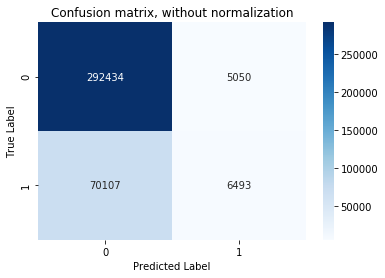

In [74]:
conf_matrix(Y_test, Y_pred_GB2)

In [79]:
print(classification_report(Y_test, Y_pred_GB2))

              precision    recall  f1-score   support

         0.0       0.81      0.98      0.89    297484
         1.0       0.56      0.08      0.15     76600

    accuracy                           0.80    374084
   macro avg       0.68      0.53      0.52    374084
weighted avg       0.76      0.80      0.73    374084



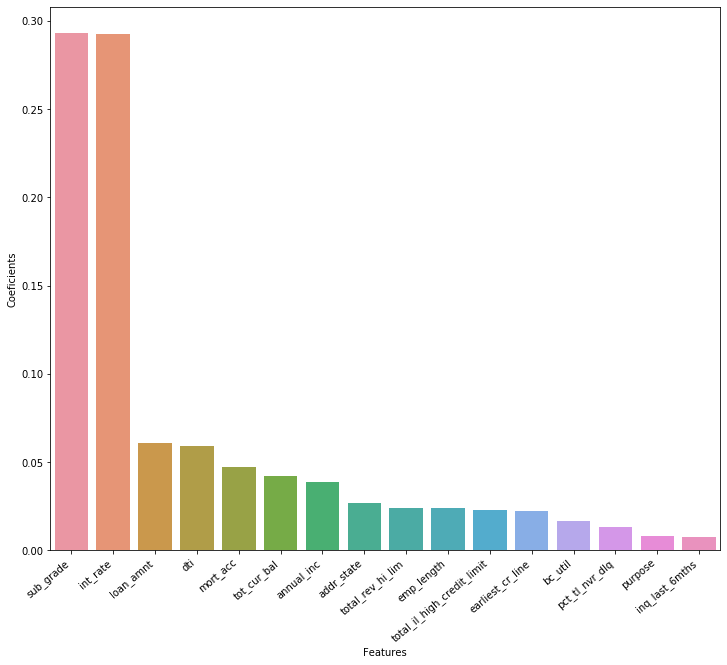

In [82]:
features_importence(tuned.feature_importances_)

The features that the model indicates as more important in predicting the defaulter's are: 'sub_grade' and 'in_rate', as in Random with  random search model.

In [76]:
y_pred2 = tuned.predict_proba(X_test)[:,1] 

In [77]:
logit_fpr, logit_tpr, _ = roc_curve(Y_test, y_pred2)
logit_auc = np.round(auc(logit_fpr, logit_tpr), 4)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
C:\ProgramData\Anaconda3\lib\site-packages\IPython\core\pylabtools.py:128: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


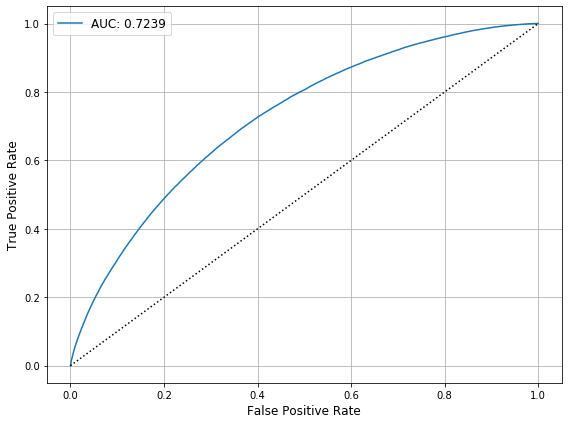

In [78]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(logit_fpr, logit_tpr, label='AUC: ' + str(logit_auc))
ax.plot(logit_fpr, logit_fpr, 'k:')
ax.set_xlabel('False Positive Rate', fontsize=12)
ax.set_ylabel('True Positive Rate', fontsize=12)
ax.legend(fontsize=12)
ax.grid(True)
plt.tight_layout()
plt.show()

In this model we get 0.80 % of accuracy in train and 0.79% of accuracy in test, ,as in XGBoost with random search model.

In the confusion matrix we can see that in 4247 of the cases the model predicted the negative class incorrectly, to be a positive class. However, of the clients in 70980 of the cases, the model incorrectly predicted that the positive class would be the negative class.

We see that in the possitive class, the precision is 0.81, recall is 0.98 and f1-score is 0.89. In the negative class the precision is 0.56, recall is 0.08 and f1-score is 0.15.

In this case we see in the ROC Curve that the AUC is 0.7239 best value of all models.

## 6.6. Ensemble

In this model we will stablish a two step classification process training a second algorithm with the values that our first model have missclassified. The we will combine both models with a function.

In [29]:
Y_train_predict = XGBoost_RS.predict(X_train)

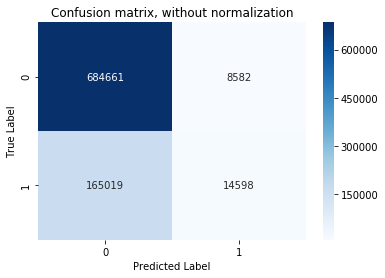

In [30]:
conf_matrix(Y_train, Y_train_predict)

For the second model we select all the individual that have been missclassified and combine them with a random sample of the individual that were classified correctly as good payer (0)

In [31]:
misclassified = np.where(Y_train != Y_train_predict)[0]
misclassified

array([     2,      8,     10, ..., 872848, 872851, 872855], dtype=int64)

In [32]:
good_payers = np.where((Y_train == Y_train_predict) & (Y_train == 0))

In [33]:
indexes = np.random.choice(684661,320000, replace=False)

In [35]:
zeros_good = good_payers[0][indexes]
zeros_good

array([  4515, 676963, 724292, ..., 335140, 691225, 179846], dtype=int64)

In [37]:
select_from_training = np.concatenate((zeros_good, misclassified))
select_from_training

array([  4515, 676963, 724292, ..., 872848, 872851, 872855], dtype=int64)

In [40]:
X_train2 = X_train.iloc[select_from_training]

In [41]:
Y_train2 = Y_train[select_from_training]

In [42]:
# %%time
# 
# param_test1 = {
#     'gamma':[i/10.0 for i in range(0,5)],
#     'learnin_rate': [i/20 for i in range(1,5)],
#     'subsample': [0.6,0.7,0.8,0.9],
#     'colsample_bytree': [0.6,0.7,0.8,0.9,1],
#     'max_depth':range(3,10,2),
#     'min_child_weight':range(1,10,2),
#     'scale_pos_weight': [1]
#              }
# model2 = RandomizedSearchCV(estimator = xgb.XGBClassifier(n_estimators=50, seed=0),
#                         param_distributions = param_test1, scoring='roc_auc',n_jobs=5, cv=3)
# model2.fit(X_train2,Y_train2)

In [20]:
# pickle.dump(modelo2, open('../models/modelo2_wo_smote.sav', 'wb'))

In [43]:
model2 = pickle.load(open('../models/modelo2_wo_smote.sav', 'rb'))

In [45]:
Y_pred_pred = model2.predict(X_train2)

In [46]:
print("XGBoost score train: ", accuracy_score(Y_train2, Y_pred_pred))

XGBoost score train:  0.6920609966349339


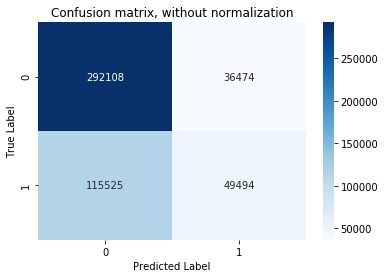

In [47]:
conf_matrix(Y_train2, Y_pred_pred)

In [48]:
print(classification_report(Y_train2, Y_pred_pred))

              precision    recall  f1-score   support

         0.0       0.72      0.89      0.79    328582
         1.0       0.58      0.30      0.39    165019

    accuracy                           0.69    493601
   macro avg       0.65      0.59      0.59    493601
weighted avg       0.67      0.69      0.66    493601



In [51]:
def ensemble(X_test):
    Y_pred = XGBoost_RS.predict(X_test)
    indexes = list(np.where(Y_pred == 0)[0])
    Y_pred_pred = list(model2.predict(X_test.iloc[indexes]))
    for index in range(0,len(indexes)):
        Y_pred[indexes[index]] = Y_pred_pred[index]
    return Y_pred

In [52]:
final = ensemble(X_test)

In [53]:
print("XGBoost score test: ", accuracy_score(Y_test, final))

XGBoost score test:  0.7638364645373766


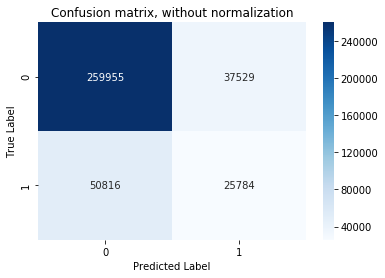

In [54]:
conf_matrix(Y_test, final)

In [55]:
print(classification_report(Y_test, final))

              precision    recall  f1-score   support

         0.0       0.84      0.87      0.85    297484
         1.0       0.41      0.34      0.37     76600

    accuracy                           0.76    374084
   macro avg       0.62      0.61      0.61    374084
weighted avg       0.75      0.76      0.76    374084



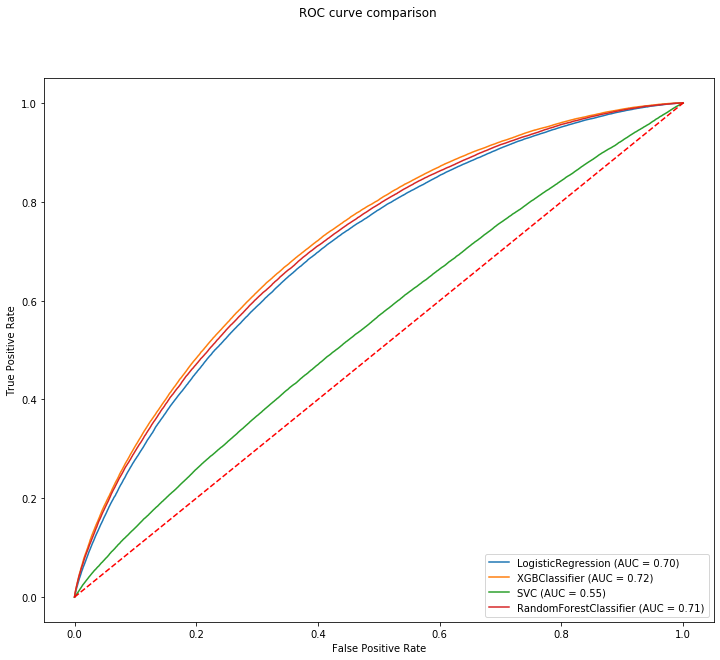

In [36]:
plt.rcParams["figure.figsize"] = (12,10)
loan_LR_disp = metrics.plot_roc_curve(logreg, X_test, Y_test)
loan_XGBoost_disp = metrics.plot_roc_curve(XGBoost_RS, X_test, Y_test, ax=loan_LR_disp.ax_)
loan_SVM2_disp = metrics.plot_roc_curve(SVC_rs, X_test, Y_test, ax=loan_XGBoost_disp.ax_)
loan_RandomForest_disp = metrics.plot_roc_curve(Forest_RS, X_test, Y_test, ax=loan_SVM2_disp.ax_)
loan_LR_disp.figure_.suptitle("ROC curve comparison")
plt.plot([0, 1], [0, 1],'r--')
plt.savefig("images/ROCs.jpg", bbox_inches="tight")
plt.show()